In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [11]:
dataset_url = 'https://www.kaggle.com/datasets/aneesh10/cricket-shot-dataset'


In [12]:
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ishanupadhyay1210
Your Kaggle Key: ··········


100%|██████████| 645M/645M [00:15<00:00, 42.5MB/s]

In [13]:
data_dir = './cricket-shot-dataset/data'
import os

In [14]:
os.listdir(data_dir)

['pullshot', 'drive', 'legglance-flick', 'sweep']

In [15]:
dataset = ImageFolder(data_dir)

In [16]:
import torchvision.transforms as tt
normalize = tt.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
)

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64), 
                                            tt.ToTensor()]))

In [17]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(4252, 472)

In [18]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(4252, 472)

In [19]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=3, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=3, 
                    pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [21]:
# Base class for model training and validation

class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss  = F.cross_entropy(out, labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss':loss.detach(), 'val_acc':acc}
    def validation_epoch_end(self, outputs):
        loss = [x['val_loss'] for x in outputs]
        acc = [x['val_acc'] for x in outputs]
        epoch_loss = torch.stack(loss).mean()
        epoch_acc = torch.stack(acc).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
    def epoch_end(self,epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [22]:
# Class of model


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [24]:
def fit(epochs, max_lr, model, train_loader, val_loader,
       weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                               steps_per_epoch = len(train_loader))
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [25]:
epochs = 12
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [26]:
model = ResNet9(3,4)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()


In [28]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

to_device(model, device)

# Transfering tensors to device whether CPU or GPU

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [29]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# DataLoader Class

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

#Wrapping the dalaloaders with our custom dataloader class

In [31]:
history = fit(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00205, train_loss: 1.4831, val_loss: 1.3403, val_acc: 0.4682
Epoch [1], last_lr: 0.00598, train_loss: 1.1395, val_loss: 1.9741, val_acc: 0.4977
Epoch [2], last_lr: 0.00935, train_loss: 1.0751, val_loss: 2.7640, val_acc: 0.3791
Epoch [3], last_lr: 0.00994, train_loss: 1.2235, val_loss: 1.3354, val_acc: 0.5740
Epoch [4], last_lr: 0.00933, train_loss: 0.9569, val_loss: 1.7445, val_acc: 0.4061
Epoch [5], last_lr: 0.00812, train_loss: 0.6203, val_loss: 1.5951, val_acc: 0.5444
Epoch [6], last_lr: 0.00647, train_loss: 0.4598, val_loss: 0.6432, val_acc: 0.7633
Epoch [7], last_lr: 0.00463, train_loss: 0.3190, val_loss: 0.2503, val_acc: 0.9205
Epoch [8], last_lr: 0.00283, train_loss: 0.2016, val_loss: 0.1722, val_acc: 0.9387
Epoch [9], last_lr: 0.00133, train_loss: 0.1209, val_loss: 0.1250, val_acc: 0.9544
Epoch [10], last_lr: 0.00035, train_loss: 0.0821, val_loss: 0.1400, val_acc: 0.9602
Epoch [11], last_lr: 0.00000, train_loss: 0.0772, val_loss: 0.1263, val_acc: 0.9602


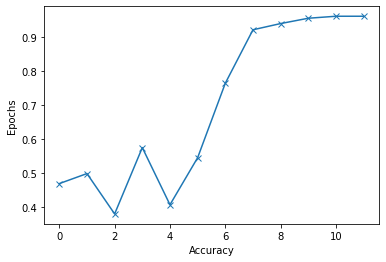

In [37]:
def accuracy_plot(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('Accuracy')
  plt.ylabel('Epochs')
  return

accuracy_plot(history)

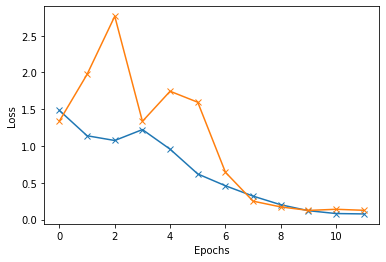

In [38]:
def loss_plot(history):
  train_losses = [x['train_loss'] for x in history]
  valid_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses,'-x')
  plt.plot(valid_losses,'-x')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.show()
  return

loss_plot(history)